Filename (no extensions!) Run4_20


----------------------------------------------------------


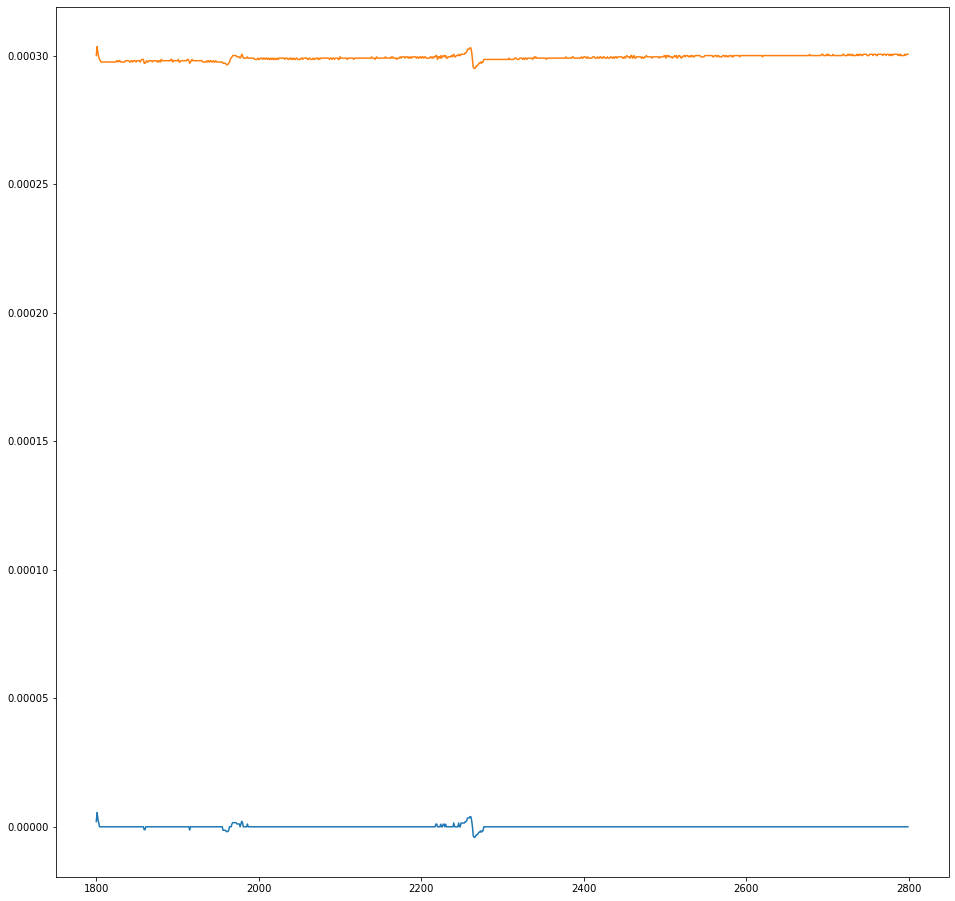

In [428]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.optimize as opt
import scipy.ndimage as ndi
import statistics as stat
import sys
import tkinter as tk
from tkinter import filedialog
#----------------------------------------------------------
pi = 3.14159265358979323846
wStart = 0 #automatically set
wEnd = 12000
peak_min_width = 2 #required peak width to count as an absorptive peak
STD = 0.70     #required sigma to count as an absorptive peak
PTP = 2        #required peak-to-peak distance (in sigma) to count as an elastic peak
WTH = 1200 #width multiplier for CI (confidence interval) to completely include peak
σS = 30    #smoothing for initial peak finding def:30
θErr =1.5    #angle offset (max absolute value in radians)
AMax = 1000       #max |amplitude| 
#----------------------------------------------------------
#root = tk.Tk()
#root.withdraw()

#file_path = filedialog.askopenfilename()
#file = open(file_path)
def fileOpen():
    try:
        file = open(input("Filename (no extensions!)")+'.txt')
        print("----------------------------------------------------------")
        return file
    except:
        print("ERROR: Incorrect Filename")
        file = fileOpen()
    if 'file' in locals():
        return file
    else:
        fileOpen()
file = fileOpen()
#----------------------------------------------------------
#DATA STRIP
def dataStrip():
    n = 0
    wStrt,wEn=0,0
    lines = []
    for x in file:  
        ### Ignore first two lines ##
        if n==0:
            ws = x.strip().split("kHz")
            wStrt =int(1000*float(ws[0]))
            wEn =int(1000*float(ws[1][(15):-1]))
            n +=1
        elif n==1:
            n +=1
        else:
            ### Remove '\n' from elements ###
            t = x.strip()
            temp = t.split('\t')
            lines.append(temp)
    #----------------------------------------------------------
    #DATA ARRAY
    wL,rL,xL,yL = [],[],[],[]
    for line in lines:
        wL.append(float(line[0]))
        rL.append(float(line[1]))
        xL.append(float(line[2]))
        yL.append(float(line[3]))
    f,r,x,y=np.array(wL),np.array(rL),np.array(xL),np.array(yL)
    return f,r,x,y,wStrt,wEn
#----------------------------------------------------------
f,r,x,y,wStart,wEnd = dataStrip() #//for some reason this doesn't work in output (wStart and end need to be global?)
#----------------------------------------------------------
def bkg(w_in,m,b):
    return (w_in*m + b)
def firstShift(w,x):
    x_bkg_p, x_bkg_COV = opt.curve_fit(bkg, w, x)
    x_bkg = bkg(w,x_bkg_p[0],x_bkg_p[1])
    x_shift = x.copy()-x_bkg
    return x_shift, x_bkg_p
def peaks(w,_x):
    σ = stat.stdev(_x)
    TRHLD = 1.5*σ
    _clean = [0]*len(w)
    for f in range(0,len(w)):
        if((_x[f]<TRHLD) and (_x[f]>-TRHLD)):
            _clean[f]=_x[f]
    _peak_data = []#[[init, final w],[//,//]..]
    st = 0;
    collect = False
    for f in range(0,len(w)-1):
        if(_clean[f]==0 and _clean[f+1]!=0):
            _peak_data.append([st,f])
            collect = True
        if(_clean[f]!=0 and _clean[f+1]==0):
            st = f
    j=0
    for i in range(0,len(_peak_data)):
        length = (_peak_data[j][1] - _peak_data[j][0])
        if(length<=20):
            _peak_data.pop(j)
            j-=1
        j+=1
    r = _x - _clean
    return _clean,r,_peak_data
def secondShift(w,x):
    _x1,x_p = firstShift(w,x)
    return (peaks(w,_x1),x_p)
#------------------
def ela(w_in, λ, w0, A, sgn):#elastic
    return sgn*A*(pow(w0,2) - pow(w_in,2))/(pow((pow(w0,2) - pow(w_in,2)),2) + pow(λ*w_in,2))
def arp(w_in, λ, w0, A, sgn):#absorptive
    return sgn*A*λ*w_in/(pow((pow(w0,2) - pow(w_in,2)),2) + pow(λ*w_in,2)) 
def R(w_in, λ, w0, A):
    return np.sqrt(pow(ela(w_in, λ, w0, A,1),2)+pow(arp(w_in, λ, w0, A, 1),2))
def posFit(f_in, λ, w0, A, m, b):
    w_in = 2*pi*f_in
    return R(w_in, λ, w0, A)+bkg(f_in,m,b)
def negFit(f_in, λ, w0, A, m, b):
    w_in = 2*pi*f_in
    return -R(w_in, λ, w0, A)+bkg(f_in,m,b)
def peakFilt(peaks,f):
    _peaks = []
    for peak in peaks:
        d = peak[1]-peak[0]
        sig = (WTH-1)/2
        st = int(peak[0]-WTH)#st = int(peak[0]-sig*d)
        if(st<0):
            st = 0
        ed = int(peak[1]+WTH)#ed = int(peak[1]+sig*d)
        if(ed>=len(f)):
            ed = len(f)-1
        _peaks.append([st,ed])
    return _peaks
#------------------
plt.figure(figsize=(16,16))
peaks,x_bkg_p = secondShift(f,r)
clean,r0,peaks = peaks
eps= 0.0000001
epsM= 0.0000000001
plt.plot(f,r0)
plt.plot(f,r)
#plt.plot(w,clean)
#print("PEAKS: ",f[_peaks[:]])
_peaks = peakFilt(peaks,f)
for i in range(0,len(_peaks)):
    x = int((_peaks[i][0]+_peaks[i][1])/2.0)
    Fguess = f[x]
    bounds=([1,f[_peaks[i][0]]*2*pi,0,x_bkg_p[0]-epsM,x_bkg_p[1]-eps], [200,f[_peaks[i][1]]*2*pi,400,x_bkg_p[0]+epsM,x_bkg_p[1]+eps])
    bounds2=([0,f[_peaks[i][0]]*2*pi,0,-10000*epsM,-100000*eps], [2000,f[_peaks[i][1]]*2*pi,400,10000*epsM,100000*eps])
    idx = f[_peaks[i][0]:_peaks[i][1]]
    #-------------------------------------
    p0 = [50,Fguess*2*pi,200,x_bkg_p[0],x_bkg_p[1]]
    #-------------------------------------
    #test value
    vA = r0[x]
    if(vA>=0):
        fit_p, fit_COV = opt.curve_fit(posFit,idx,r[_peaks[i][0]:_peaks[i][1]],p0=p0,bounds=bounds,maxfev=10000000)
        fit_p, fit_COV = opt.curve_fit(posFit,idx,r[_peaks[i][0]:_peaks[i][1]],p0=fit_p,bounds=bounds2,maxfev=10000000)
        plt.plot(f , posFit(f, fit_p[0], fit_p[1], fit_p[2], fit_p[3], fit_p[4]))
    else:
        fit_p, fit_COV = opt.curve_fit(negFit,idx,r[_peaks[i][0]:_peaks[i][1]],p0=p0,bounds=bounds,maxfev=10000000)
        fit_p, fit_COV = opt.curve_fit(negFit,idx,r[_peaks[i][0]:_peaks[i][1]],p0=fit_p,bounds=bounds2,maxfev=10000000)
        plt.plot(f , negFit(f, fit_p[0], fit_p[1], fit_p[2], fit_p[3], fit_p[4]))
    #-------------------------------------
    print("---------------")
    print("R Amplitude:\t\t", fit_p[2],"\nResonance Frequency:\t" , fit_p[1]/(2*pi), "Hz\nQuality:\t\t" , fit_p[1]/(fit_p[0]),"\nGamma:\t\t\t" , (fit_p[0]))
    print("\n-\ LinearFit: y =",fit_p[3],"x +",fit_p[4])
    plt.plot(idx,r[_peaks[i][0]:_peaks[i][1]])
    plt.axvspan(f[_peaks[i][0]], f[_peaks[i][1]], color='cyan', alpha=0.1)

In [33]:
%matplotlib  inline